# Testing bias metrics and mitigation algorithms on the Compas dataset

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from numpy.random import default_rng
from collections import OrderedDict
from copy import deepcopy
sns.set_theme(style='darkgrid')

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.datasets import BinaryLabelDataset, CompasDataset
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover

In [23]:
# utility functions
def compute_dataset_fairness_metrics(data: BinaryLabelDataset, unpriv_group: list, priv_group: list):
    """ Computes: Disparate Impact and Statistical Parity """
    
    b = BinaryLabelDatasetMetric(data, unprivileged_groups=unpriv_group, privileged_groups=priv_group)
    metrics = dict()
    metrics['Disparate Impact'] = b.disparate_impact()
    metrics['Statistical Parity'] = b.statistical_parity_difference()
    for k in metrics:
        print("%s = %.4f" % (k, metrics[k]))
    return metrics

def compute_fairness_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Computes: Balanced Accuracy 
    Statistical Parity Difference
    Disparate Impact
    Average odds difference
    Equal Opportunity Difference
    Theil Index """
    
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

def compute_quality_metrics(dataset_true, dataset_pred, unprivileged_group, privileged_group):
    clm = ClassificationMetric(dataset_true, dataset_pred, unprivileged_group, privileged_group)
    p_metrics = OrderedDict()
    u_metrics = OrderedDict()
    p_metrics['Precision'] = clm.precision(privileged=True)
    p_metrics['Recall'] = clm.recall(privileged=True)
    p_metrics['F1 Score'] = (2*p_metrics['Precision']*p_metrics['Recall'])/(p_metrics['Precision']+p_metrics['Recall'])
    
    u_metrics['Precision'] = clm.precision(privileged=False)
    u_metrics['Recall'] = clm.recall(privileged=False)
    u_metrics['F1 Score'] = (2*u_metrics['Precision']*u_metrics['Recall'])/(u_metrics['Precision']+u_metrics['Recall'])
    return p_metrics, u_metrics

def build_dataset(n_samples, n_features, n_informative, n_sensitive):
    """"Builds a syntetic dataset for classification"""
    x, y = make_classification(n_samples=n_samples, 
                               n_features=n_features, 
                               n_informative=n_informative)
    data = pd.DataFrame(np.column_stack((x,y)), columns=[i for i in range(11)])
    s = np.arange(n_sensitive)
    s = np.repeat(s,n_samples/2)
    rnd = default_rng()
    rnd.shuffle(s)
    data['s'] = s
    return data

def split_data(data: BinaryLabelDataset):
    #data = BinaryLabelDataset(df=data, label_names=label_names, protected_attribute_names=protect_attr_names)
    data_train, data_tv = data.split([0.7], shuffle=True)
    data_test, data_valid = data_tv.split([0.5], shuffle=True)
    return data_train, data_test, data_valid

def x_y_split(train, test, sensitive_attributes=[]):
    x_train = train.features
    x_test = test.features
    y_train = train.labels.ravel()
    y_test = test.labels.ravel()
    for s in sensitive_attributes:
        x_train = np.delete(train.features, train.feature_names.index(s), axis=1)
        x_test = np.delete(test.features, test.feature_names.index(s), axis=1)
    return x_train, y_train, x_test, y_test

def compute_classification_metrics(estimator: Pipeline, valid_data: BinaryLabelDataset):
    
    """"Computes the bias classification metrics 
    in addition to the classification report and a confusion matrix"""
    pred = valid_data.copy()
    pred.labels = estimator.predict(pred.features)
    plot_classification_report(classification_report(valid_data.labels, pred.labels))
    plot_confusion_matrix(valid_data.labels, pred.labels, {'1', '0'}, normalize=True)
    class_metrics = compute_fairness_metrics(valid_data, pred, unprivileged_group, privileged_group)
    return class_metrics

def merge_datasets(datasets: dict):
    keys = list(datasets.keys())
    first_data = datasets.pop(keys[0])
    merged_metrics = pd.DataFrame(first_data, index=[0])
    merged_metrics.loc[0,'Dataset'] = keys[0]
    index = 1
    for k,v in datasets.items():
        merged_metrics = merged_metrics.append(v, ignore_index=True)
        merged_metrics.loc[index,'Dataset'] = k
        index = index + 1
    merged_data = merged_metrics.melt(id_vars='Dataset', value_name='values', var_name='metrics')
    return merged_data

In [200]:
def classify(estimator: Pipeline, 
             data: BinaryLabelDataset, 
             priv_group: list=privileged_group, 
             unpriv_group: list=unprivileged_group, 
             sensitive_attributes = [], show=True):
    np_data = np.hstack((data.features, data.labels))
    kf = KFold(n_splits=10, shuffle=True)
    class_metrics = []
    quality_metrics_p = []
    quality_metrics_u = []
    for train, test in kf.split(np_data):
        d_train = data.subset(train)
        d_test = data.subset(test)
        x_train, y_train, x_test, y_test = x_y_split(d_train, d_test, sensitive_attributes)
        if sensitive_attributes:
            indexes = [d_train.feature_names.index(s) for s in sensitive_attributes]
            d_train.features = np.delete(d_train.features, indexes, axis=1)
        pipe = deepcopy(estimator)
        pipe.fit(x_train, y_train, logisticregression__sample_weight=d_train.instance_weights.ravel())
        pred = d_test.copy()
        pred.labels = pipe.predict(x_test)
        metric = compute_fairness_metrics(d_test, pred, unpriv_group, priv_group, disp=False)
        q_metric_p, q_metric_u = compute_quality_metrics(d_test, pred, unpriv_group, priv_group)
        quality_metrics_p.append(q_metric_p)
        quality_metrics_u.append(q_metric_u)
        class_metrics.append(metric)
    
    ris = {key: round(np.mean([metric[key] for metric in class_metrics]),4) for key in class_metrics[0]}
    q_metrics_p = {key: round(np.mean([metric[key] for metric in quality_metrics_p]),4) for key in quality_metrics_p[0]}
    q_metrics_u = {key: round(np.mean([metric[key] for metric in quality_metrics_u]),4) for key in quality_metrics_u[0]}
    q_metrics = pd.DataFrame(data=[q_metrics_p, q_metrics_u], index=['Privileged', 'Unprivileged'])
    plot_quality_metrics(q_metrics)
    if show:
        for key, val in ris.items():
            print("%s: %.4f" % (key,val))
    return ris

def balance_set(w_exp, w_obs, df, tot_df, round_level, debug=False):
    disparity = [round(w_exp/w_obs,round_level)]
    while(round(w_exp/w_obs,round_level) != 1):
        if w_exp/w_obs > 1:
            df = df.append(df.sample())
        elif w_exp/w_obs < 1:
            df = df.drop(df.sample().index, axis=0)
        w_obs = len(df)/len(tot_df)
        disparity.append(round(w_exp/w_obs,round_level))
        if debug:
            print(w_exp/w_obs)
    return df, disparity

def sample_dataset(dataframe: pd.DataFrame, 
                   privileged_attributes_condition: bool, 
                   unprivileged_attributes_condition: bool, 
                   fav_label: bool,
                   unfav_label: bool,
                   protected_attribute_names: list,
                   label: str,
                   round_level=0):   
    ps_df = dataframe.copy()
    DP = ps_df[(unprivileged_attributes_condition)&(fav_label)]
    DN = ps_df[(unprivileged_attributes_condition)& (unfav_label)]
    FP = ps_df[(privileged_attributes_condition)&(fav_label)]
    FN = ps_df[(privileged_attributes_condition)&(unfav_label)]

    w_exp_dp = (len(ps_df[unprivileged_attributes_condition])/len(ps_df))*(len(ps_df[fav_label])/len(ps_df))
    w_exp_dn = (len(ps_df[unprivileged_attributes_condition])/len(ps_df))*(len(ps_df[unfav_label])/len(ps_df))
    w_exp_fp = (len(ps_df[privileged_attributes_condition])/len(ps_df))*(len(ps_df[fav_label])/len(ps_df))
    w_exp_fn = (len(ps_df[privileged_attributes_condition])/len(ps_df))*(len(ps_df[unfav_label])/len(ps_df))
  
    w_obs_dp = len(DP)/len(ps_df)
    w_obs_dn = len(DN)/len(ps_df)
    w_obs_fp = len(FP)/len(ps_df)
    w_obs_fn = len(FN)/len(ps_df)

    DP, dp_disparity = balance_set(w_exp_dp, w_obs_dp, DP, ps_df, round_level)
    DN, dn_disparity = balance_set(w_exp_dn, w_obs_dn, DN, ps_df, round_level)
    FP, fp_disparity = balance_set(w_exp_fp, w_obs_fp, FP, ps_df, round_level)
    FN, fn_disparity = balance_set(w_exp_fn, w_obs_fn, FN, ps_df, round_level)
    df_new = DP.append([DN, FP, FN]).sample(frac=1)
    ax = plot_groups_disparity(dp_disparity, dn_disparity, fp_disparity, fn_disparity)
    return BinaryLabelDataset(df=df_new, protected_attribute_names=protected_attribute_names, label_names=[label]), ax

In [198]:
# plot functions
def plot_groups_disparity(dp_disparity, dn_disparity, fp_disparity, fn_disparity):
    fig, ax = plt.subplots()
    sns.lineplot(data=dp_disparity,label='DP')
    sns.lineplot(data=dn_disparity, label='DN')    
    sns.lineplot(data=fp_disparity, label='FP')    
    sns.lineplot(data=fn_disparity, label='FN')
    plt.axhline(y=1, linewidth=2)
    plt.legend()
    ax.set_ylabel('Group disparity')
    return ax

def plot_confusion_matrix(cm,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    classes = {'1', '0'}
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plot_quality_metrics(q_metrics):
    ax = sns.heatmap(q_metrics, annot=True, cmap=plt.cm.RdBu)
    plt.ylabel('Classes')
    plt.xlabel('Metrics')
    plt.yticks(rotation=0)
    plt.title('Classification Report')
    plt.tight_layout()
    return ax

def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:-4]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()

def plot_metrics_comparison(bias_class_metrics, rw_class_metrics, title1='', title2=''):
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    keys = list(bias_class_metrics.keys())
    vals = [float(bias_class_metrics[k]) for k in keys]
    sns.barplot(x=keys, y=vals,ax=ax[0])
    for k in keys:
        ax[0].text(keys.index(k), 
                   bias_class_metrics[k], 
                   round(bias_class_metrics[k], 3), 
                   ha="center",
                   va="bottom",
                   fontsize="medium"
                  )
    keys = list(rw_class_metrics.keys())
    vals = [float(rw_class_metrics[k]) for k in keys]
    sns.barplot(x=keys, y=vals,ax=ax[1])
    for k in keys:
        ax[1].text(keys.index(k), 
                   rw_class_metrics[k], 
                   round(rw_class_metrics[k], 3), 
                   ha="center",
                   va="bottom",
                   fontsize="medium"
                  )
    ax[0].tick_params(labelrotation=90)
    ax[0].set(title=title1)
    ax[1].tick_params(labelrotation=90)
    ax[1].set(title=title2)
    return ax

def plot_syntesis(dataset, title):
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    unbias_fig = sns.barplot(data = dataset, x='metrics', y='values', hue='Dataset', ax=ax)
    plt.ylabel(ylabel='')
    plt.xlabel(xlabel='')
    plt.title(title)
    return ax

## Dataset Description

COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is a popular commercial algorithm used by judges and parole officers for scoring criminal defendant’s likelihood of reoffending (recidivism). It has been shown that the algorithm is biased in favor of white defendants, and against black inmates, based on a 2 year follow up study (i.e who actually committed crimes or violent crimes after 2 years). The pattern of mistakes, as measured by precision/sensitivity is notable.

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the unsensitive variables at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the unsensitive attributes are changed s.t. the correlation between the variables and the sensitive attribute _S_ is removed while keeping the ranking of the items for the classifier.
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier. 

<!--3. **LFR**

> Learning fair representations is a pre-processing technique that finds a latent representation which encodes the data well but obfuscates information about protected attributes-->

# Importing and exploring the dataset

In [102]:
compas = CompasDataset(features_to_drop=['age_cat'])

In [103]:
compas.protected_attribute_names

['sex', 'race']

In [104]:
compas.metadata['protected_attribute_maps']

[{0.0: 'Male', 1.0: 'Female'}, {1.0: 'Caucasian', 0.0: 'Not Caucasian'}]

In [105]:
compas.label_names

['two_year_recid']

In [106]:
compas.favorable_label

0.0

In [107]:
compas_df = compas.convert_to_dataframe()[0]

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


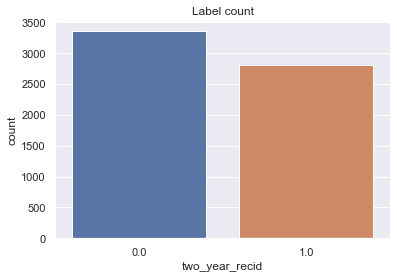

In [108]:
sns.countplot(x='two_year_recid', data=compas_df)
plt.title("Label count")
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


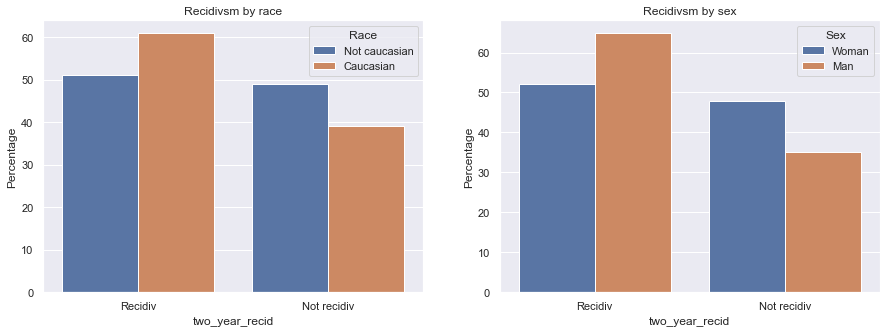

In [109]:
fig, [ax1, ax2] = plt.subplots(1,2,figsize=(15,5))
score_group = (compas_df.groupby(['race'])['two_year_recid']
              .value_counts(normalize=True).rename('Percentage').mul(100).reset_index())
score_group_sex = (compas_df.groupby(['sex'])['two_year_recid']
              .value_counts(normalize=True).rename('Percentage').mul(100).reset_index())
sns.barplot(data=score_group_sex, x='two_year_recid', y='Percentage', hue='sex', ax=ax2)
ax2.set_xticklabels({'Not recidiv', 'Recidiv'})
leg = ax2.legend()
leg.set_title('Sex')
leg.get_texts()[0].set_text('Woman')
leg.get_texts()[1].set_text('Man')
ax2.set_title('Recidivsm by sex')
sns.barplot(data=score_group, x='two_year_recid', y='Percentage', hue='race', ax=ax1)
ax1.set_xticklabels({'Not recidiv', 'Recidiv'})
leg = ax1.legend()
leg.set_title('Race')
leg.get_texts()[0].set_text('Not caucasian')
leg.get_texts()[1].set_text('Caucasian')
ax1.set_title('Recidivsm by race')
plt.show()

So we are in a **Balanced bias dataset** case

# Bias dataset and classification metrics

In [110]:
unprivileged_group = [{'race': 0, 'sex': 0}]
privileged_group = [{'race': 1, 'sex': 1}]

## Bias dataset case

### Dataset metrics

In [111]:
metrics = compute_dataset_fairness_metrics(compas, unprivileged_group, privileged_group)

Disparate Impact = 0.7480
Statistical Parity = -0.1627


### Classification metrics

Balanced accuracy: 0.6585
Statistical parity difference: -0.3933
Disparate impact: 0.5235
Average odds difference: -0.3609
Equal opportunity difference: -0.3027
Theil index: 0.2358


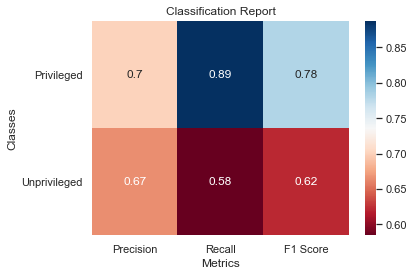

In [112]:
class_metrics = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), compas)

## Reweighing

In [113]:
rw_data = compas.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_data = rw.fit_transform(rw_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


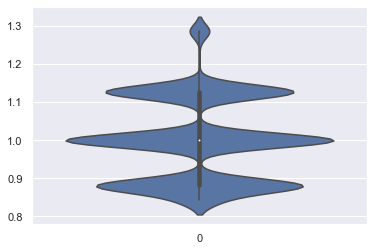

In [114]:
sns.violinplot(data=rw_data.instance_weights)
plt.show()

### Dataset metrics

In [115]:
metrics = compute_dataset_fairness_metrics(rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Classification metrics

Balanced accuracy: 0.6533
Statistical parity difference: -0.0950
Disparate impact: 0.8753
Average odds difference: -0.0988
Equal opportunity difference: -0.0578
Theil index: 0.2078


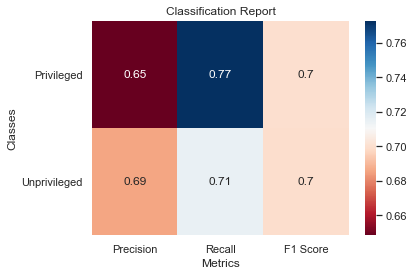

In [116]:
rw_class = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                    rw_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


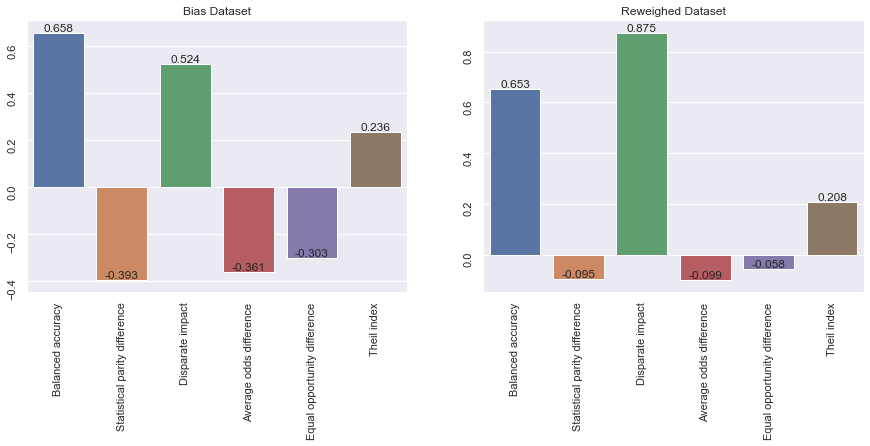

In [117]:
plot_metrics_comparison(class_metrics, rw_class, "Bias Dataset", "Reweighed Dataset")
plt.show()

## Disparate Impact

Since we have two sensitive attributes, DIR requires to create an attribute that is the joint probability distribution of the two sensitive attributes and to transform the unsensitive variables with respect to this new variable:

In [154]:
dir_data = compas.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)

In [155]:
df = dir_data.convert_to_dataframe()[0]
probs = (
    df.value_counts(["sex", "race"], normalize=True).unstack().reset_index()
    .melt(id_vars='sex', value_vars=[0.0,1.0], var_name='race', value_name='probs'))

In [156]:
for sex,race,prob in probs.values:
    df.loc[(df['sex'] == sex) & (df['race'] == race), 'prob'] = prob

In [157]:
df.drop(df[['sex','race']], axis=1, inplace=True)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


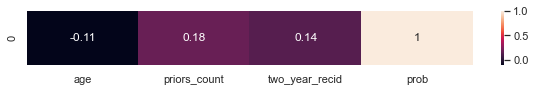

In [158]:
corr = df.corrwith(df['prob'], drop=True)
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr[(abs(corr[0])>0.1)].T, annot=True)
plt.show()

In [159]:
probs

,sex,race,probs
0,0.0,0.0,0.547106
1,1.0,0.0,0.112372
2,0.0,1.0,0.262689
3,1.0,1.0,0.077834


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


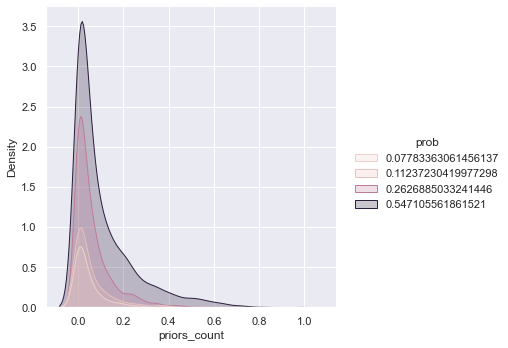

In [160]:
sns.displot(data=df, x='priors_count', hue='prob', kind='kde', multiple='layer', fill=True)
plt.show()

In [161]:
di = DisparateImpactRemover(sensitive_attribute='prob')
dir_data = BinaryLabelDataset(df=df, label_names=['two_year_recid'], protected_attribute_names=['prob'])
dir_data = di.fit_transform(dir_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


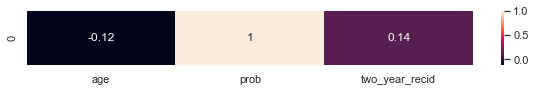

In [162]:
df_dir = dir_data.convert_to_dataframe()[0]
corr = df_dir.corrwith(df['prob'], drop=True)
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr[(abs(corr[0])>0.1)].T, annot=True)
plt.show()

In [168]:
df.loc[df['prob'].round(6) == 0.077834, 'prob'] = 1
df.loc[df['prob'].round(6) != 1, 'prob'] = 0

df_dir.loc[df_dir['prob'].round(6) == 0.077834, 'prob'] = 1
df_dir.loc[df_dir['prob'].round(6) != 1, 'prob'] = 0

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


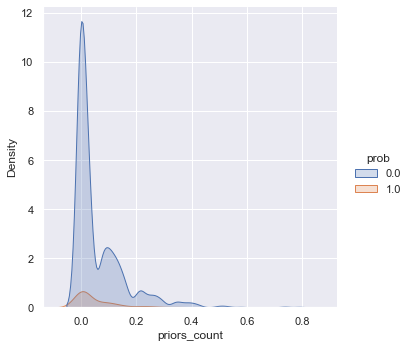

In [169]:
sns.displot(data=df_dir, x='priors_count', hue='prob', kind='kde', multiple='layer', fill=True)
plt.show()

### Dataset Metrics

In [170]:
prob_priv_group = [{'prob': 1}]
prob_unpriv_group = [{'prob': 0}]
dir_data = BinaryLabelDataset(df=df_dir, label_names=['two_year_recid'], protected_attribute_names=['prob'])

In [171]:
metrics = compute_dataset_fairness_metrics(dir_data, prob_unpriv_group, prob_priv_group)

Disparate Impact = 1.3102
Statistical Parity = 0.1099


Balanced accuracy: 0.6645
Statistical parity difference: 0.1090
Disparate impact: 1.3172
Average odds difference: 0.0724
Equal opportunity difference: 0.0587
Theil index: 0.2226


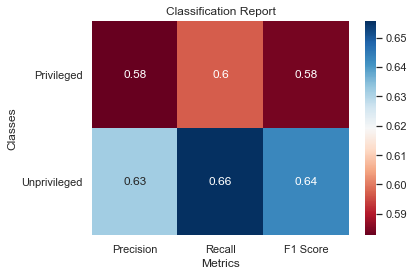

In [172]:
dir_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    dir_data, priv_group = prob_priv_group, unpriv_group = prob_unpriv_group, sensitive_attributes=['prob'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


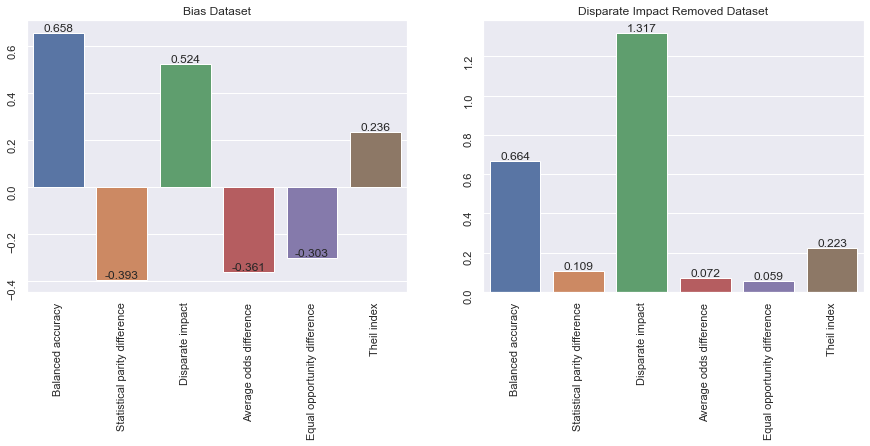

In [173]:
plot_metrics_comparison(class_metrics, dir_class, 'Bias Dataset', 'Disparate Impact Removed Dataset')
plt.show()

## Modified Reweighing (Sampling)

### Double sensitive attributes

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


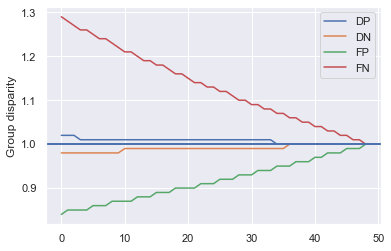

In [201]:
sampled_data = sample_dataset(compas_df, 
                              (compas_df['sex']==1)&(compas_df['race']==1),
                              (compas_df['sex']==0)|(compas_df['race']==0),
                              compas_df['two_year_recid']==0,
                              compas_df['two_year_recid']==1,
                              ['sex', 'race'], 'two_year_recid', 2)
plt.show()

In [151]:
metrics = compute_dataset_fairness_metrics(sampled_data, unprivileged_group, privileged_group)

Disparate Impact = 1.1251
Statistical Parity = 0.0568


Balanced accuracy: 0.6580
Statistical parity difference: 0.2625
Disparate impact: 2.0460
Average odds difference: 0.2424
Equal opportunity difference: 0.2956
Theil index: 0.2358


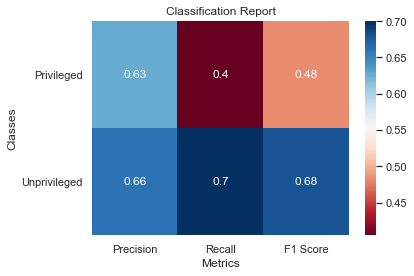

In [183]:
sampled_metrics = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), sampled_data)

### Joint probability distribution

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


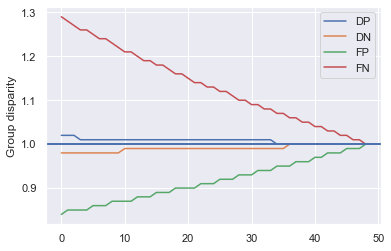

In [202]:
sampled_prob_data = sample_dataset(df, df['prob']==1, df['prob']==0, df['two_year_recid']==0, 
                                   df['two_year_recid']==1, ['prob'], 'two_year_recid', round_level=2)
plt.show()

In [178]:
metrics = compute_dataset_fairness_metrics(sampled_prob_data, prob_unpriv_group, prob_priv_group)

Disparate Impact = 1.0082
Statistical Parity = 0.0037


Balanced accuracy: 0.6619
Statistical parity difference: -0.0285
Disparate impact: 0.9679
Average odds difference: -0.0291
Equal opportunity difference: -0.0329
Theil index: 0.2305


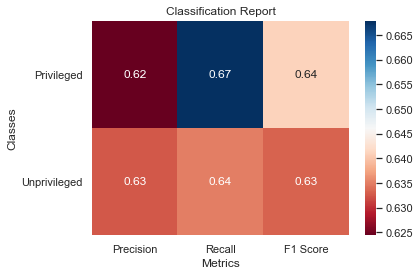

In [180]:
sampled_prob_metrics = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
                                sampled_prob_data, prob_priv_group, prob_unpriv_group)

Compute the **Reweighing** with the joint probability and confront the results:

In [193]:
rw_prob_data = BinaryLabelDataset(df=df, label_names=['two_year_recid'], protected_attribute_names=['prob'])
rw = Reweighing(prob_unpriv_group, prob_priv_group)
rw_prob_data = rw.fit_transform(rw_prob_data)

Balanced accuracy: 0.6606
Statistical parity difference: -0.0248
Disparate impact: 0.9668
Average odds difference: -0.0200
Equal opportunity difference: -0.0061
Theil index: 0.2326


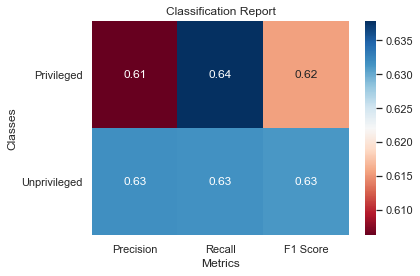

In [194]:
rw_prob_metrics = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
                           rw_prob_data, prob_priv_group, prob_unpriv_group)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


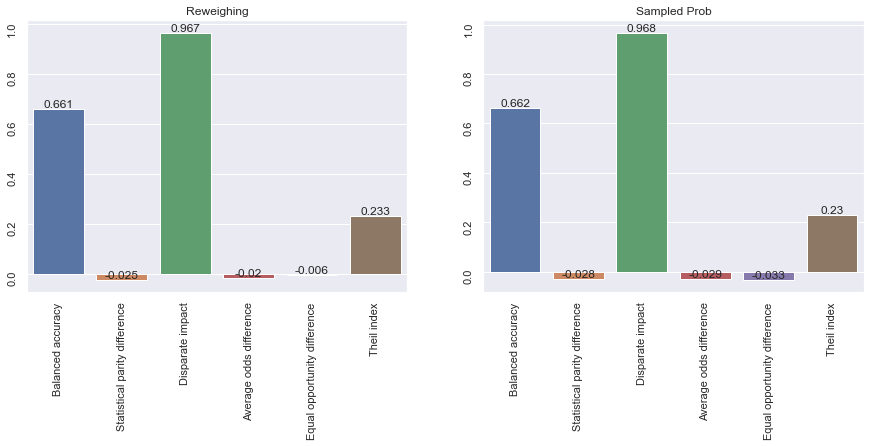

In [195]:
plot_metrics_comparison(rw_prob_metrics, sampled_prob_metrics, 'Reweighing', 'Sampled Prob')
plt.show()

## Reweighing + DIR

In [185]:
rw_dir_data = dir_data.copy()
rw = Reweighing(prob_unpriv_group, prob_priv_group)

In [186]:
rw_dir_data = rw.fit_transform(rw_dir_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


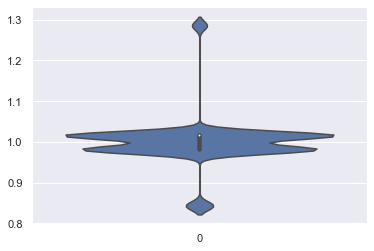

In [187]:
sns.violinplot(data= rw_dir_data.instance_weights)
plt.show()

### Dataset Metrics

In [188]:
metrics = compute_dataset_fairness_metrics(rw_dir_data, prob_unpriv_group, prob_priv_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Classification Metrics

Balanced accuracy: 0.6618
Statistical parity difference: 0.0695
Disparate impact: 1.1969
Average odds difference: 0.0645
Equal opportunity difference: 0.0383
Theil index: 0.2249


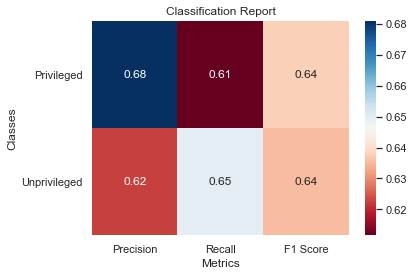

In [189]:
rw_dir_score = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_dir_data, priv_group=prob_priv_group, unpriv_group=prob_unpriv_group, sensitive_attributes=rw_dir_data.protected_attribute_names)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


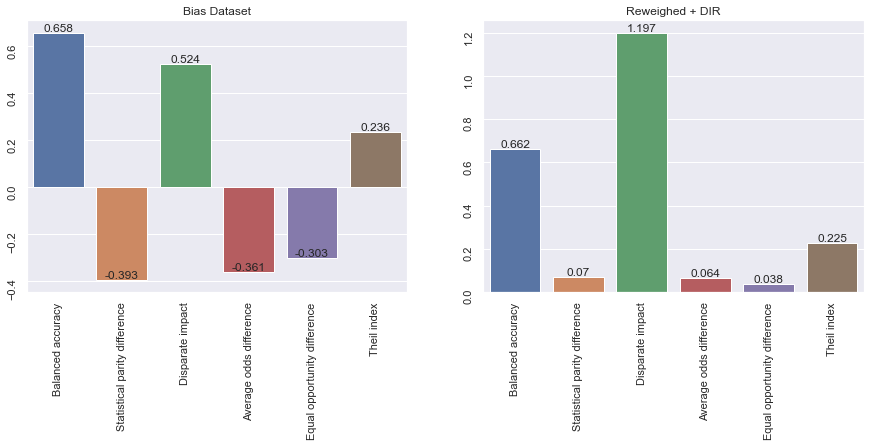

In [190]:
plot_metrics_comparison(class_metrics, rw_dir_score, 'Bias Dataset', 'Reweighed + DIR')
plt.show()

## Algorithms Comparison

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


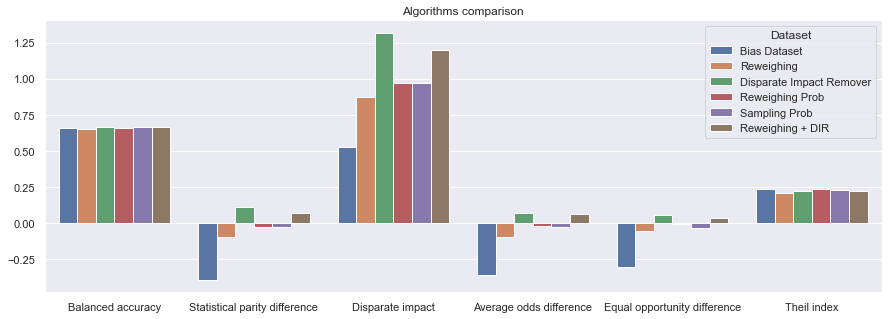

In [196]:
plot_syntesis(merge_datasets({
    'Bias Dataset': class_metrics,
    'Reweighing': rw_class,
    'Disparate Impact Remover': dir_class,
    'Reweighing Prob': rw_prob_metrics,
    'Sampling Prob': sampled_prob_metrics,
    'Reweighing + DIR': rw_dir_score
}), 'Algorithms comparison')
plt.show()